In [1]:
import pandas as pd
import os
import numpy as np

In [ ]:
os.environ["OPENAI_API_KEY"] = ""    #add your OpenAI API key

In [3]:
# read data

data = pd.read_csv("data.csv", usecols=['message_clean'])
data.head()

,message_clean
0,aethero support trouble find clear documentati...
1,experience critical issue user permission prod...
2,aethero support experience urgent issue deploy...
3,aethero support team write improvement api dev...
4,aethero support quick question api monitor das...


In [4]:
# tokenize data

docs = data["message_clean"].tolist()

In [5]:
# create bigram tokenizer
from sklearn.feature_extraction.text import CountVectorizer

bigram_vectorizer = CountVectorizer(
    ngram_range=(2, 2),    # Only bigrams
    max_features=1000      # Top 1000 bigrams by frequency
)

In [6]:
# set model to train on tokenized data for bigrams in random state
from turftopic import FASTopic

topic_size  = 10
model = FASTopic(n_components = topic_size, 
                 vectorizer = bigram_vectorizer,
                 random_state = 32).fit(docs)

Output()

[19:10:48] Documents encoded.                                                                       ]8;id=139638;file://c:\Users\xpetr\.conda\envs\Turftopic\Lib\site-packages\turftopic\models\fastopic.py\fastopic.py]8;;\:]8;id=835926;file://c:\Users\xpetr\.conda\envs\Turftopic\Lib\site-packages\turftopic\models\fastopic.py#157\157]8;;\

           Term extraction done.                                                                    ]8;id=198507;file://c:\Users\xpetr\.conda\envs\Turftopic\Lib\site-packages\turftopic\models\fastopic.py\fastopic.py]8;;\:]8;id=970603;file://c:\Users\xpetr\.conda\envs\Turftopic\Lib\site-packages\turftopic\models\fastopic.py#161\161]8;;\

[19:10:53] Model fitting done.                                                                      ]8;id=476732;file://c:\Users\xpetr\.conda\envs\Turftopic\Lib\site-packages\turftopic\models\fastopic.py\fastopic.py]8;;\:]8;id=556269;file://c:\Users\xpetr\.conda\envs\Turftopic\Lib\site-packages\turftopic\models\fastopic.py#164\164]8;;\

In [7]:
topics_df = model.topics_df()

# First, split and explode
topics_df.columns = ['topic_id', 'topic_words']
topics_df['topic_word'] = topics_df['topic_words'].str.split(',')
topics_df = topics_df.explode('topic_word')

# Add a rank for each word within a topic (optional, for row order)
topics_df['word_rank'] = topics_df.groupby('topic_id').cumcount() + 1

# Pivot to wide format: columns are (topic_id, topic_name), rows are word_rank, values are topic_word
wide = topics_df.pivot(index='word_rank', columns=['topic_id'], values='topic_word')
wide

topic_id,0,1,2,3,4,5,6,7,8,9
word_rank,,,,,,,,,,
1,iam role,api performance,issue mercury,latency spike,write improvement,deploy mercury,issue api,project mercury,business operation,role iam
2,access resource,real time,error mercury,spike api,team write,deployment process,api develop,work project,estimate time,role inheritance
3,issue iam,rely heavily,compiler error,intermittent latency,rate limit,aethero cloud,provide update,support work,time resolution,achieve this
4,aetheros iam,average response,unexpected token,experience intermittent,api development,mercury application,api gateway,error handle,advise asap,developer role
5,role user,however suggestion,late version,high latency,support team,issue deploy,investigate urgently,error handling,issue cloud,role base
6,unable access,false positive,language compiler,support notice,support write,experience difficulty,disruption service,trouble find,major outage,inherit permission
7,urgent issue,potential issue,face critical,assistance identify,incredibly helpful,aetheros cloud,team experience,language api,complete outage,service specifically
8,issue aetheros,improvement api,advise proceed,spike latency,management service,encounter error,urgently provide,clear documentation,production api,access control
9,assign role,monitor dashboard,environment mercury,latency issue,dear aethero,issue thank,update possible,async await,cloud instance,access specific


In [8]:
# fit model to data
topic_data = model.prepare_topic_data(docs)

# create document-term matrix
dtm = topic_data.document_topic_matrix

# assign topics to each document
topic_assignments = np.argmax(dtm, axis=1)
topics = topic_assignments.tolist()

# Merge topic assignments with data on index
data_with_topics = data.copy()
data_with_topics['topic_assignment'] = topic_assignments

In [9]:
# use the Namer to label topics
from turftopic.namers import OpenAITopicNamer

namer = OpenAITopicNamer("gpt-4o-mini")
model.rename_topics(namer)

Output()

In [10]:
# create a dataframe with labelled topics
topics_df = model.topics_df()
topics_df.columns = ['topic_id', 'topic_name', 'topic_words']

,topic_id,topic_name,topic_words
0,0,IAM Role Access Issues,"iam role, access resource, issue iam, aetheros..."
1,1,API Performance Monitoring and Improvement,"api performance, real time, rely heavily, aver..."
2,2,Mercury Compiler Issues,"issue mercury, error mercury, compiler error, ..."
3,3,Latency Issues and Support,"latency spike, spike api, intermittent latency..."
4,4,Collaborative API Development Support,"write improvement, team write, rate limit, api..."
5,5,Mercury Application Deployment Challenges,"deploy mercury, deployment process, aethero cl..."
6,6,API Service Disruption Response,"issue api, api develop, provide update, api ga..."
7,7,Project Mercury: Async Error Handling Support,"project mercury, work project, support work, e..."
8,8,Cloud Outage Response Management,"business operation, estimate time, time resolu..."
9,9,Role-Based Access Control in IAM,"role iam, role inheritance, achieve this, deve..."


In [11]:
# Wide format with topic_id as columns and topic_words as values
wide_topics = topics_df.pivot_table(
    index=None, 
    columns='topic_id', 
    values='topic_words', 
    aggfunc='first'
)

# Add topic names as a second row
wide_topics.columns = [f"{col}: {topics_df.loc[topics_df['topic_id']==col, 'topic_name'].values[0]}" for col in wide_topics.columns]

In [ ]:
# Reshape to wide format: each topic_id/topic_name is a column, each row is a topic_word rank

# First, split and explode
# topics_long = topics_df.copy()s
topics_df['topic_word'] = topics_df['topic_words'].str.split(',')
topics_df = topics_df.explode('topic_word')
topics_df['topic_word'] = topics_df['topic_word'].str.strip()

# Add a rank for each word within a topic (optional, for row order)
topics_df['word_rank'] = topics_df.groupby('topic_id').cumcount() + 1

# Pivot to wide format: columns are (topic_id, topic_name), rows are word_rank, values are topic_word
wide = topics_df.pivot(index='word_rank', columns=['topic_id', 'topic_name'], values='topic_word')

# For MultiIndex columns: keep columns where the first level is numeric
wide_numeric = wide[[col for col in wide.columns if str(col[0]).isdigit()]]

In [14]:
wide

topic_id,0,1,2,3,4,5,6,7,8,9
topic_name,IAM Role Access Issues,API Performance Monitoring and Improvement,Mercury Compiler Issues,Latency Issues and Support,Collaborative API Development Support,Mercury Application Deployment Challenges,API Service Disruption Response,Project Mercury: Async Error Handling Support,Cloud Outage Response Management,Role-Based Access Control in IAM
word_rank,,,,,,,,,,
1,iam role,api performance,issue mercury,latency spike,write improvement,deploy mercury,issue api,project mercury,business operation,role iam
2,access resource,real time,error mercury,spike api,team write,deployment process,api develop,work project,estimate time,role inheritance
3,issue iam,rely heavily,compiler error,intermittent latency,rate limit,aethero cloud,provide update,support work,time resolution,achieve this
4,aetheros iam,average response,unexpected token,experience intermittent,api development,mercury application,api gateway,error handle,advise asap,developer role
5,role user,however suggestion,late version,high latency,support team,issue deploy,investigate urgently,error handling,issue cloud,role base
6,unable access,false positive,language compiler,support notice,support write,experience difficulty,disruption service,trouble find,major outage,inherit permission
7,urgent issue,potential issue,face critical,assistance identify,incredibly helpful,aetheros cloud,team experience,language api,complete outage,service specifically
8,issue aetheros,improvement api,advise proceed,spike latency,management service,encounter error,urgently provide,clear documentation,production api,access control


In [15]:
# Remove MultiIndex: flatten columns to single level by joining with underscore
wide_flat = wide.copy()
if isinstance(wide_flat.columns, pd.MultiIndex):
    wide_flat.columns = [': '.join([str(i) for i in col if i != '']) for col in wide_flat.columns]

In [16]:
cleaned_column_list = []

for col in wide_flat.columns.tolist():
    # Remove numbers and colons from each column name
    cleaned_col = ''.join(char for char in str(col) if not char.isdigit() and char != ':')
    cleaned_col = cleaned_col.strip()  # Remove extra whitespace
    if cleaned_col:  # Only add non-empty strings
        cleaned_column_list.append(cleaned_col)

In [17]:
# Remove MultiIndex: flatten columns to single level by joining with underscore
wide_flat = wide.copy()
if isinstance(wide_flat.columns, pd.MultiIndex):
    wide_flat.columns = [': '.join([str(i) for i in col if i != '']) for col in wide_flat.columns]

# # Now keep only columns where the name starts with a digit
wide_numeric = wide_flat[[col for col in wide_flat.columns if str(col)[0].isdigit()]]

# Create list of tuples following the structure (topic_id, topic_name, topic_words)
topics_list = []

for column in wide_numeric.columns:
    # Extract topic_id from column name (first part before colon)
    topic_id = int(column.split(':')[0])
    
    # Extract topic_name from column name (part after colon)
    topic_name = column.split(':', 1)[1].strip()
    
    # Get all words for this topic (non-null values in this column)
    words = wide_numeric[column].dropna().tolist()
    topic_words = ', '.join(words)
    
    # Create tuple and add to list
    topics_list.append((topic_id, topic_name, topic_words))

# Sort by topic_id to ensure proper order
topics_list.sort(key=lambda x: x[0])

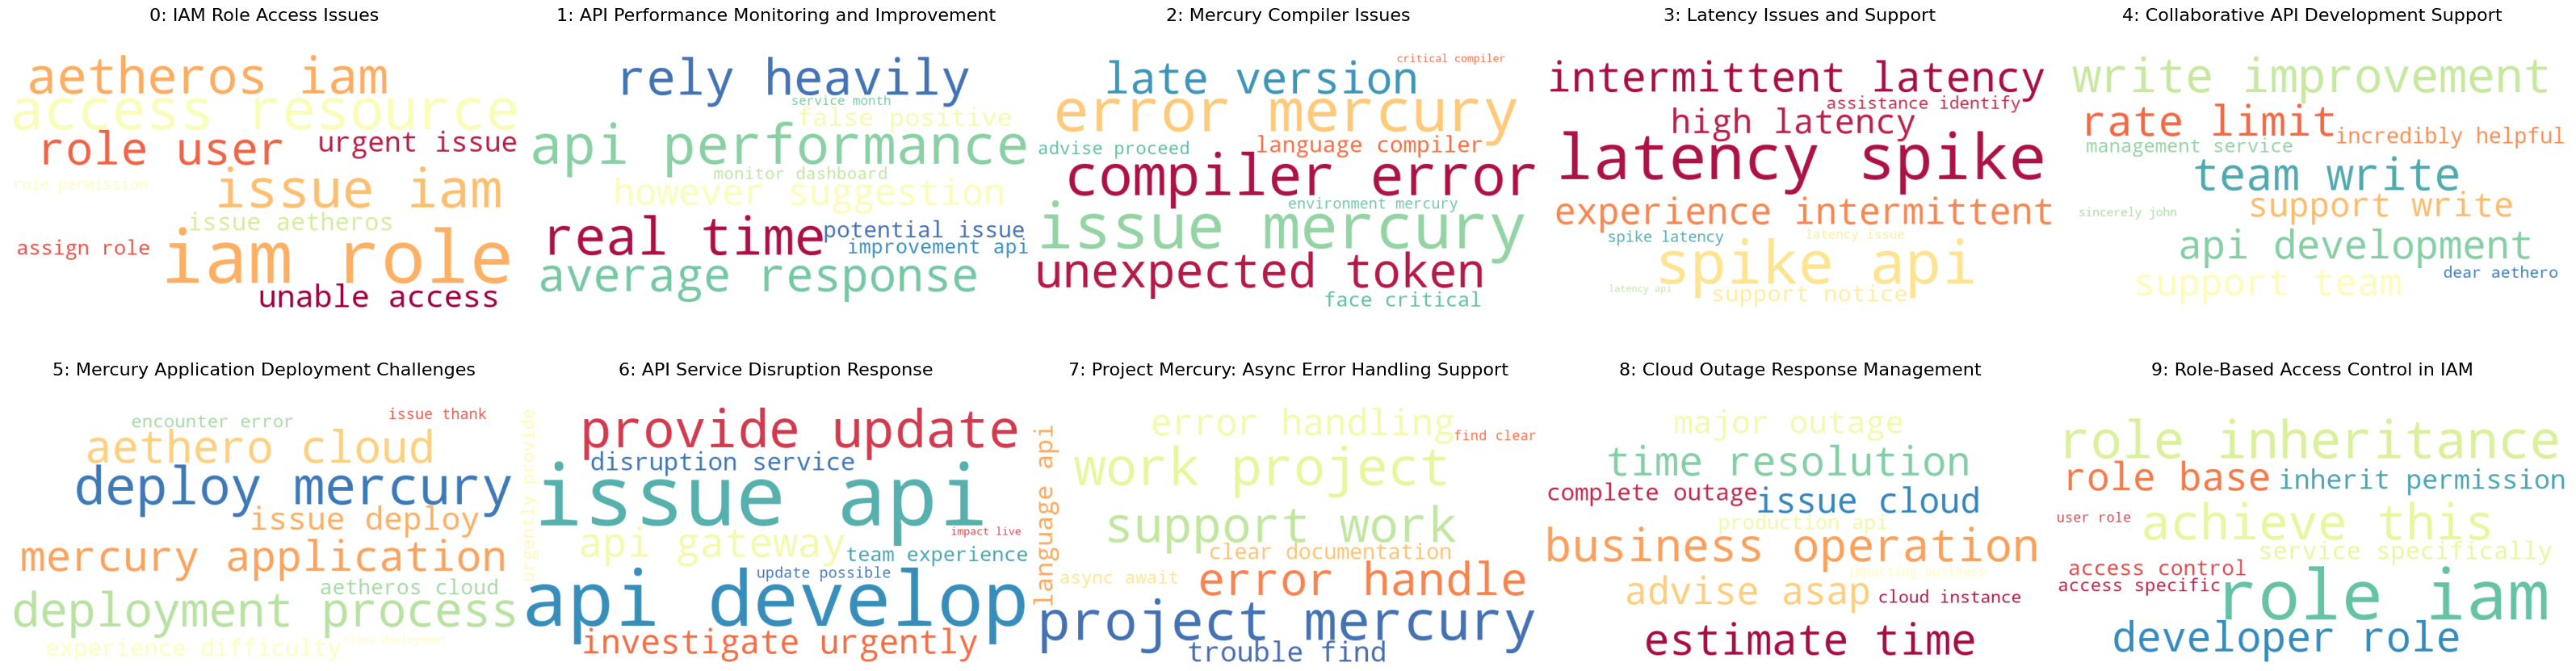

In [18]:
# visualize the topics in bigram word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(32, 12))
axes = axes.flatten()

for idx, (topic_id, topic_name, keywords) in enumerate(topics_list):
    raw_tokens = keywords.split(", ")
    tokens = [token.strip().replace("ˍ", " ") for token in raw_tokens]
    freqs = {token: len(tokens) - i for i, token in enumerate(tokens)}

    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          colormap='Spectral', collocations=False).generate_from_frequencies(freqs)

    axes[idx].imshow(wordcloud, interpolation='bilinear')
    # Shift title above the axes, normal weight
    axes[idx].set_title(f"{topic_id}: {topic_name}", fontsize=16, weight='normal', y=1.1)
    axes[idx].axis("off")

# Remove extra subplot axes (if any)
for j in range(len(topics_list), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=-0.4)
plt.savefig("FAST_10_wordcloud.png", dpi=100, bbox_inches='tight')
plt.show()